## Partition clusters based on dendrogram
 https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [347]:
from read_clustering.variant_call import VariantCalls
threshold = 0.5
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import re
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import metrics
import sys
sys.setrecursionlimit(10000)
import os

In [281]:
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
twoprimeo_pos = [ 648,  649,  662,  804,  806,  816,  866,  875,  897,  907, 1132,
       1436, 1448, 1449, 1887, 2196, 2219, 2255, 2279, 2280, 2287, 2336,
       2346, 2416, 2420, 2618, 2639, 2723, 2728, 2790, 2792, 2814, 2920,
       2921, 2945, 2947, 2958, 27,   99,  413,  419,  435,  540,  561,  577,  618,  795,  973,
       1006, 1125, 1268, 1270, 1427, 1571, 1638]

twoprimeo_pos_25 = [ 648,  649,  662,  804,  806,  816,  866,  875,  897,  907, 1132,
       1436, 1448, 1449, 1887, 2196, 2219, 2255, 2279, 2280, 2287, 2336,
       2346, 2416, 2420, 2618, 2639, 2723, 2728, 2790, 2792, 2814, 2920,
       2921, 2945, 2947, 2958]

twoprimeo_pos_18 = [27,   99,  413,  419,  435,  540,  561,  577,  618,  795,  973,
       1006, 1125, 1268, 1270, 1427, 1571, 1638]

In [285]:
pseduo_u_pos = [ 775,  959,  965,  985,  989, 1003, 1041, 1051, 1055, 1109, 1123,
       2128, 2132, 2190, 2257, 2259, 2263, 2265, 2313, 2339, 2348, 2350,
       2415, 2734, 2825, 2864, 2879, 2922, 2943, 2974, 105,  119,  210,  301,  465,  631,  758,  765,  998, 1180, 1186,
       1289, 1414]
pseduo_u_pos_18 = [105,  119,  210,  301,  465,  631,  758,  765,  998, 1180, 1186,
       1289, 1414]
pseduo_u_pos_25 = [ 775,  959,  965,  985,  989, 1003, 1041, 1051, 1055, 1109, 1123,
       2128, 2132, 2190, 2257, 2259, 2263, 2265, 2313, 2339, 2348, 2350,
       2415, 2734, 2825, 2864, 2879, 2922, 2943, 2974]

def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


In [286]:
ivt_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/final_variant_calls/canonical_ivt.csv"
WT_YPD = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/WT_YPD.csv"
cbf5_glu_psu_depletion_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/final_variant_calls/depletion_cbf5_glu_round30_alt_canonical_supervised_500_500.model.csv"
nop58_glu_2o_depletion_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/final_variant_calls/depletion_nop58_glu_round30_alt_canonical_supervised_500_500.model.csv"       
YWD448a = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/mutant448_YPD.csv"
YWD451a = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/mutant451_YPD.csv"
YWD452a = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/mutant452_YPD.csv"
WT_YPD = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/WT_YPD.csv"
mix = "/Users/andrewbailey/CLionProjects/rrna_analysis/flongle/flongle_all_csvs/Mix.csv"


## Selection of Clustering method and distance metric

In [287]:
metrics = ["euclidean", "minkowski", "cityblock", "seuclidean", "sqeuclidean", "cosine", "correlation", "hamming", "jaccard", "jensenshannon", "chebyshev", "canberra", "braycurtis", "mahalanobis", "yule", "dice", "kulsinski", "rogerstanimoto", "russellrao", "sokalmichener", "sokalsneath", "wminkowski"]
methods = ["ward", "single", "complete", "average", "weighted", "centroid", "median"]


In [308]:

# max_d = 30
# clusters = fcluster(Z, max_d, criterion='distance')
all_file_paths = [YWD448a, YWD451a, YWD452a, WT_YPD]
all_labels = ["80", "83", "88", "native"]
# all_file_paths = [cbf5_glu_psu_depletion_path, nop58_glu_2o_depletion_path, ivt_path, WT_YPD]
# all_labels = ["cbf5_glu", "nop_glu", "ivt", "native"]

vc = VariantCalls(all_file_paths, all_labels, color_map="Set1")

contigs = ["RDN18-1", "RDN25-1"]
contig = contigs[0]
X = vc.get_X(contig, vc.get_contig_positions(contig), n=350)
true_labels = X.index.get_level_values(1).map({"80":1, "83":2, "88":3, "native":4})
# true_labels = X.index.get_level_values(1).map({"cbf5_glu":1, "nop_glu":2, "ivt":3, "native":4})
all_info_scores = []
for method in methods:
    for metric in metrics:
        try: 
            Z = linkage(X, method=method, metric=metric)
#             for i in range(2, 6):
            i = 4
            cut = cut_tree(Z, n_clusters=4)
            clusters = [x[0] for x in cut]
#             clusters = fcluster(Z, i, criterion='maxclust')
            c, coph_dists = cophenet(Z, pdist(X))
            silhouette_avg = silhouette_score(X, clusters)
            info_score = adjusted_mutual_info_score(true_labels, clusters)
            all_info_scores.append([method, metric, i, info_score, c, silhouette_avg])
        except ValueError:
            pass

top_clustering = pd.DataFrame(all_info_scores)
top_clustering


,0,1,2,3,4,5
0,ward,euclidean,4,2.951783e-01,0.208884,0.034484
1,single,euclidean,4,7.361782e-07,0.665026,0.156653
2,single,minkowski,4,7.361782e-07,0.665026,0.156653
3,single,cityblock,4,7.361782e-07,0.630021,0.128730
4,single,seuclidean,4,7.361782e-07,0.635800,0.102408
...,...,...,...,...,...,...
76,weighted,kulsinski,4,2.357996e-03,0.358502,0.153592
77,weighted,rogerstanimoto,4,1.309462e-03,0.406949,0.080964
78,weighted,russellrao,4,1.230629e-01,0.227556,0.020935
79,weighted,sokalmichener,4,1.309462e-03,0.406949,0.080964


In [320]:
top_sillouette = top_clustering.sort_values(by=5, ascending=False)
sil_method=top_sillouette.iloc[0][0]
sil_metric=top_sillouette.iloc[0][1]
print("silouette:", sil_method, sil_metric)
top_coph = top_clustering.sort_values(by=5, ascending=False)
coph_method=top_coph.iloc[0][0]
coph_metric=top_coph.iloc[0][1]
print("coph:", coph_method, coph_metric)
score_top = top_clustering.sort_values(by=3, ascending=False)
score_method=score_top.iloc[0][0]
score_metric=score_top.iloc[0][1]
print("score:", score_method, score_metric)


silouette: single kulsinski
coph: single kulsinski
score: ward euclidean


ward euclidean


<IPython.core.display.Javascript object>


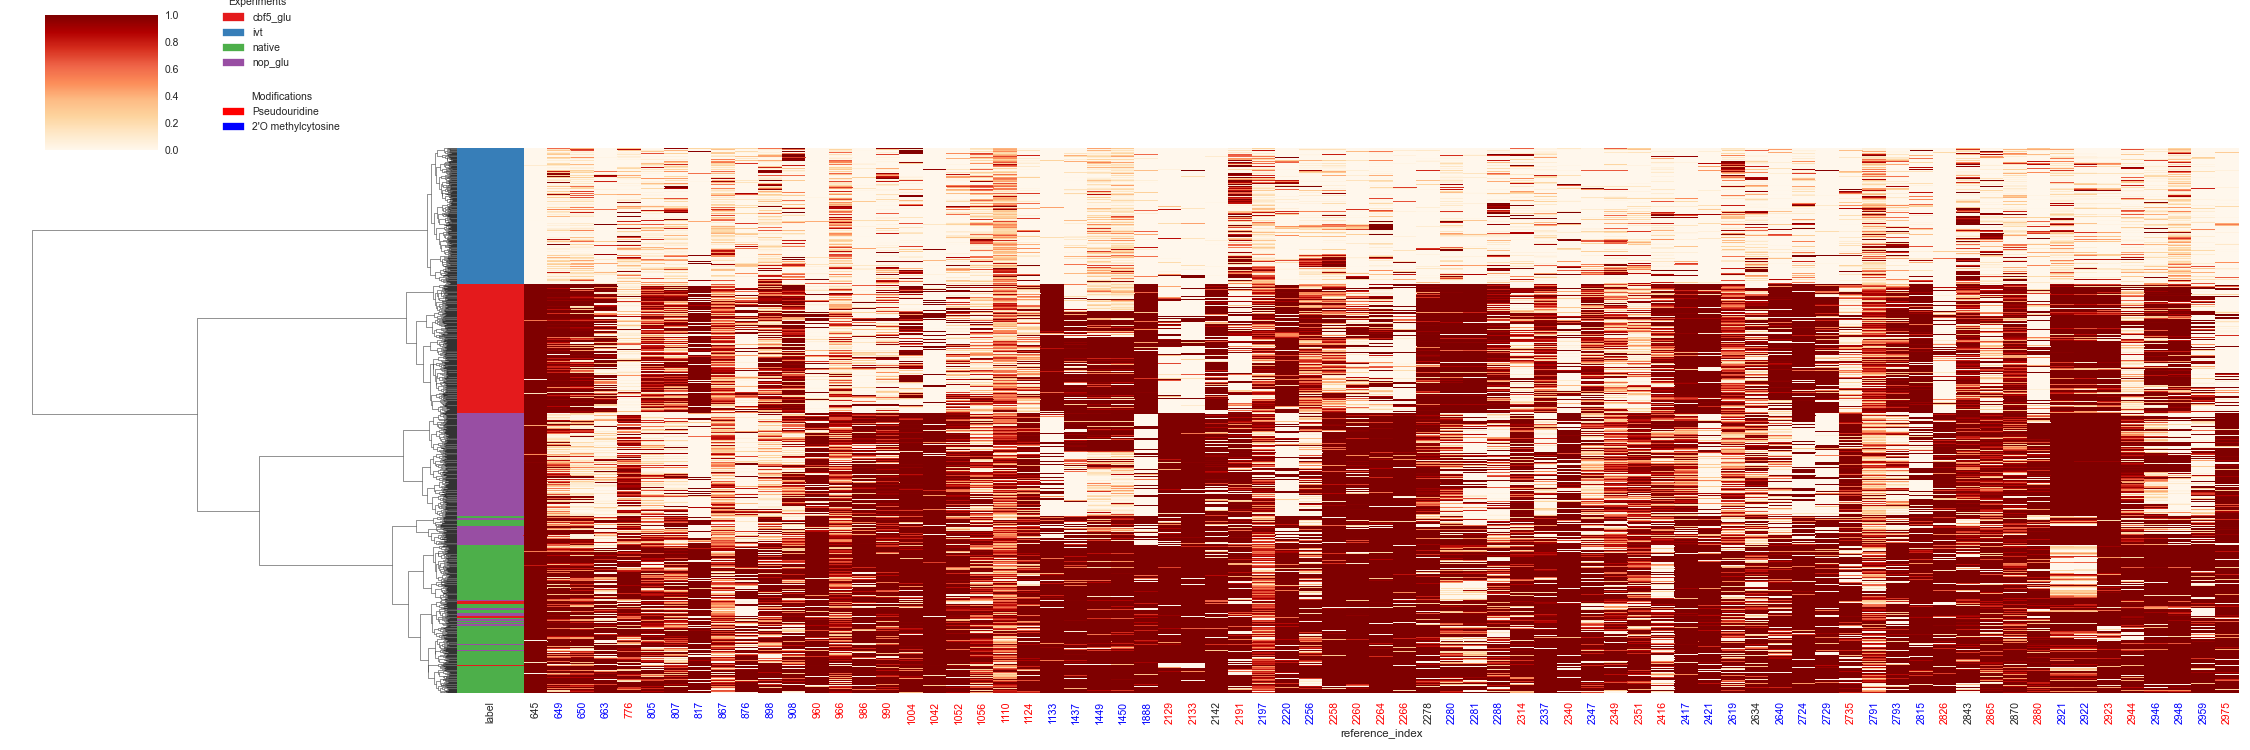

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [324]:
method="ward"
metric="euclidean"
# method="weighted"
# metric="seuclidean"
# method="average"
# metric="cityblock"
# method="single"
# metric="kulsinski"

print(method, metric)
# contig = "RDN25-1"
X = vc.get_X(contig, vc.get_contig_positions(contig), n=350)
g = vc._plot_heatmap_dendrogram(X, n=n, figure_path=save_fig_path,
                           metric=metric,
                           method=method, 
                           col_cluster=False,
                           row_cluster=True,
                           twoprimeo_pos=twoprimeo_pos,
                           pseduo_u_pos=pseduo_u_pos,
                          legend=legend,
                          figsize=figsize)


## Partition depletions into 4 clusters

In [317]:
method = "ward"
metric = "euclidean"

<IPython.core.display.Javascript object>


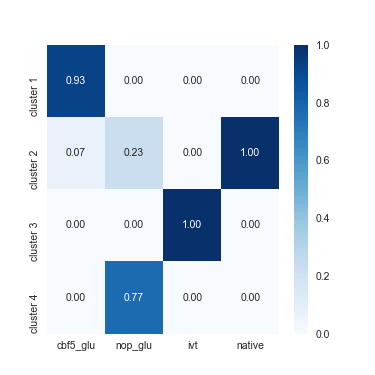

<IPython.core.display.Javascript object>


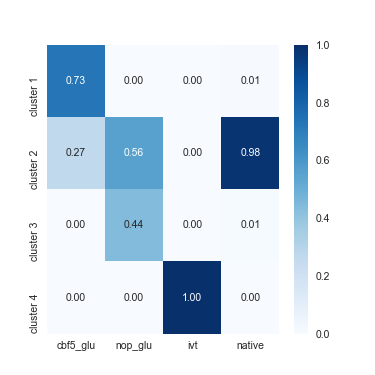

In [399]:
def get_count(count, label):
    if hasattr(count, label):
        return getattr(count, label)
    else:
        return 0
    
all_file_paths = [cbf5_glu_psu_depletion_path, nop58_glu_2o_depletion_path, ivt_path, WT_YPD]
all_labels = ["cbf5_glu", "nop_glu", "ivt", "native"]
vc = VariantCalls(all_file_paths, all_labels, color_map="Set1")

n_clusters = 4
contigs = ["RDN25-1", "RDN18-1"]
for contig in contigs:
    X = vc.get_X(contig, vc.get_contig_positions(contig), n=1000)
    Z = linkage(X, method=method, metric=metric)
    cut = cut_tree(Z, n_clusters=n_clusters)
    clusters = np.array([x[0]+1 for x in cut])
    plot_me = []
    for i in range(1, 5):
        cluster_counts = []
        counts = X[clusters == i].index.get_level_values(1).value_counts()
        for label in all_labels:
            cluster_counts.append(get_count(counts, label))
        plot_me.append(cluster_counts)
    data = pd.DataFrame(plot_me, columns=all_labels, index=[f"cluster {i}" for i in range(1, 5)])
    # plot
    f, ax = plt.subplots(figsize=(5, 5))

    figure_path = f"/Users/andrewbailey/CLionProjects/rrna_analysis/figures/percent_depletion/{contig}_depletion_fraction.svg"

    percents = (data / data.sum())
    ax = sns.heatmap(percents, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=1)

    if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
        plt.savefig(figure_path, dpi=1000)
    else:
        plt.show()

## Number of clusters selection


In [397]:
# clusters = fcluster(Z, max_d, criterion='distance')
all_file_paths = [YWD448a, YWD451a, YWD452a, WT_YPD, mix]
all_labels = ["80", "83", "88", "native", "mix"]

vc = VariantCalls(all_file_paths, all_labels, color_map="Set1")

# contigs = ["RDN18-1", "RDN25-1"]
contig = contigs[0]
X = vc.get_X(contig, vc.get_contig_positions(contig), n=500)
all_info_scores = []
Z = linkage(X, method=method, metric=metric)
# c, coph_dists = cophenet(Z, pdist(X))


for i in range(2, 10):
    cut = cut_tree(Z, n_clusters=i)
    clusters = [x[0] for x in cut]
    silhouette_avg = silhouette_score(X, clusters)
    ck_score = metrics.calinski_harabasz_score(X, clusters)
    db_score = metrics.davies_bouldin_score(X, clusters)
    s_samples = metrics.silhouette_samples(X, clusters)
#     print(i, s_samples)
#             clusters = fcluster(Z, i, criterion='maxclust')
    all_info_scores.append([method, metric, i, silhouette_avg, ck_score, db_score])

top_clustering = pd.DataFrame(all_info_scores)


In [396]:
top_clustering

,0,1,2,3,4,5
0,ward,euclidean,2,0.028352,36.569192,5.815977
1,ward,euclidean,3,0.024627,31.258119,5.042084
2,ward,euclidean,4,0.010534,27.392258,4.942666
3,ward,euclidean,5,0.009742,24.372389,5.125840
4,ward,euclidean,6,0.011627,21.245747,5.128886
5,ward,euclidean,7,0.009016,19.150990,5.225190
6,ward,euclidean,8,0.007176,17.637815,5.565489
7,ward,euclidean,9,0.002423,16.358836,5.506581


<IPython.core.display.Javascript object>


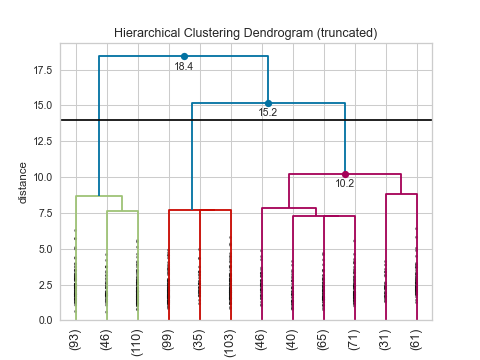

In [361]:
cutoff = 14
plt.figure()
fancy_dendrogram(
    linkage(X, method=method, metric=metric),
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=cutoff,  # plot a horizontal cut-off line
)
plt.show()


ward euclidean


<IPython.core.display.Javascript object>


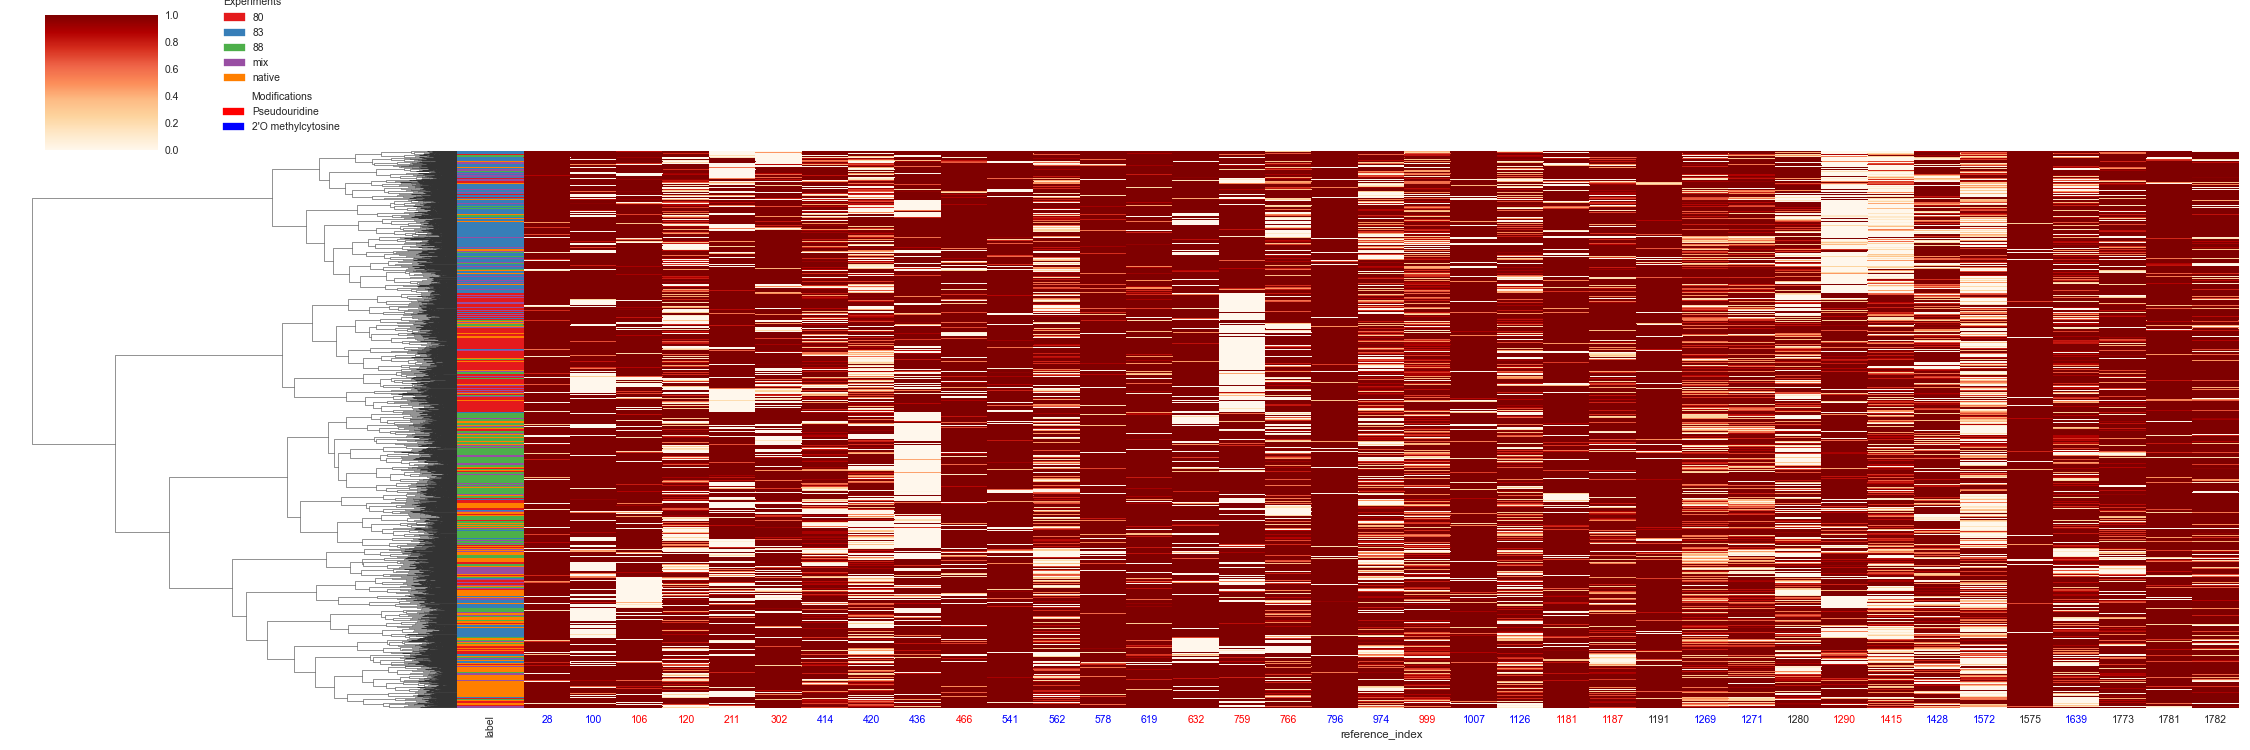

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [378]:
method="ward"
metric="euclidean"
# method="weighted"
# metric="seuclidean"
# method="average"
# metric="cityblock"
# method="single"
# metric="kulsinski"

print(method, metric)
# contig = "RDN25-1"
save_fig_path = 
X = vc.get_X(contig, vc.get_contig_positions(contig), n=500)
g = vc._plot_heatmap_dendrogram(X, n=n, figure_path=save_fig_path,
                           metric=metric,
                           method=method, 
                           col_cluster=False,
                           row_cluster=True,
                           twoprimeo_pos=twoprimeo_pos,
                           pseduo_u_pos=pseduo_u_pos,
                          legend=legend,
                          figsize=figsize)


<IPython.core.display.Javascript object>


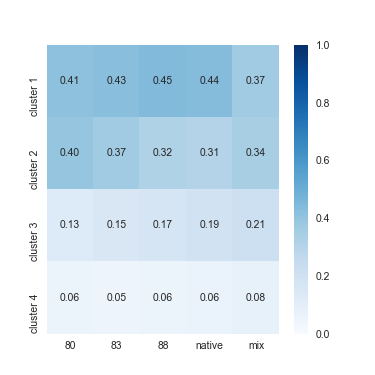

<IPython.core.display.Javascript object>


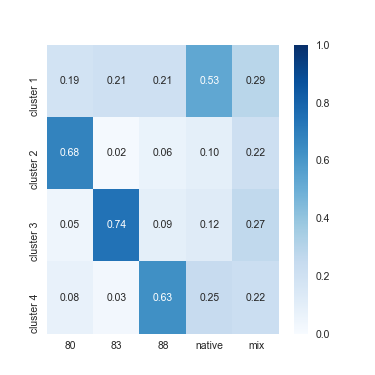

In [398]:
n_clusters = 4
contigs = ["RDN25-1", "RDN18-1"]
for contig in contigs:
    X = vc.get_X(contig, vc.get_contig_positions(contig), n=500)
    Z = linkage(X, method=method, metric=metric)
    cut = cut_tree(Z, n_clusters=n_clusters)
    clusters = np.array([x[0]+1 for x in cut])
    plot_me = []
    for i in range(1, n_clusters+1):
        cluster_counts = []
        counts = X[clusters == i].index.get_level_values(1).value_counts()
        for label in all_labels:
            cluster_counts.append(get_count(counts, label))
        plot_me.append(cluster_counts)
    data = pd.DataFrame(plot_me, columns=all_labels, index=[f"cluster {i}" for i in range(1, n_clusters+1)])
    # plot
    f, ax = plt.subplots(figsize=(5, 5))

    figure_path = f"/Users/andrewbailey/CLionProjects/rrna_analysis/figures/Figure2/{contig}_mix_fraction.svg"

    percents = (data / data.sum())
    ax = sns.heatmap(percents, cmap="Blues", annot=True, fmt=".2f", vmin=0, vmax=1)

    if figure_path is not None:
#         assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
        plt.savefig(figure_path, dpi=1000)
    else:
        plt.show()

In [ ]:
## Plot Distribution of pairwise distances
# distances = pdist(X, metric='euclidean')
# pd.DataFrame(distances).hist(bins=100)